## Import Tensorflow Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

physical_devices = tf.config.list_physical_devices('GPU') 
for gpu_instance in physical_devices: 
    tf.config.experimental.set_memory_growth(gpu_instance, True)

os.environ['TF_CPP_MIN_LOG_LEVEL']='2'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.compat.v2.logging.set_verbosity(tf.compat.v2.logging.ERROR)

2022-08-19 21:24:56.037924: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-19 21:24:56.041814: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-19 21:24:56.041950: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


## Create our Training Dataset and Validation Dataset

In [2]:
data_dir = "nvme_drive/Training Data"
AUTOTUNE = tf.data.AUTOTUNE

batch_size = 96
img_height = 240
img_width = 240
train_ds = train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.1,
  subset="training",
  seed=12322,
  image_size=(img_height, img_width),
  batch_size=batch_size)




val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.1,
  subset="validation",
  seed=12322,
  image_size=(img_height, img_width),
  batch_size=batch_size)

class_names = train_ds.class_names
num_classes = len(train_ds.class_names)
print(class_names)
print("Number of classes found: " + str(num_classes))

Found 673148 files belonging to 4 classes.
Using 605834 files for training.


2022-08-19 21:25:18.728382: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-19 21:25:18.729075: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-19 21:25:18.729237: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-19 21:25:18.729340: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

Found 673148 files belonging to 4 classes.
Using 67314 files for validation.
['Gore', 'None', 'Pornographic', 'Racy']
Number of classes found: 4


## Create Model

### Preprocessing our Data

In [3]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(img_height, img_width),
  layers.Rescaling(1./255)
])


val_ds = val_ds.map(lambda x, y: (resize_and_rescale(x), y), num_parallel_calls=AUTOTUNE)
train_ds = train_ds.map(lambda x, y: (resize_and_rescale(x), y), num_parallel_calls=AUTOTUNE)

#Data augmentation should only be applied to the training dataset
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)

In [4]:
#Buffered prefetching applied to all datasets
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)

#Caching and prefetching the validation dataset. If the execution stalls this might cause a crash because we run out of memory.
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

#val_ds = val_ds.cache()
#train_ds = train_ds.cache()

#### Set and Compile the model

In [5]:
model = tf.keras.applications.resnet50.ResNet50(weights = None, input_shape = (img_width, img_height ,3), classes=num_classes)

#model = Sequential([
#  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
#  layers.Conv2D(16, 3, padding='same', activation='relu'),
#  layers.MaxPooling2D(),
#  layers.Conv2D(32, 3, padding='same', activation='relu'),
#  layers.MaxPooling2D(),
#  layers.Conv2D(64, 3, padding='same', activation='relu'),
#  layers.MaxPooling2D(),
#  layers.Flatten(),
#  layers.Dense(128, activation='relu'),
#  layers.Dense(num_classes)
#])


model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 240, 240, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 240, 240, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 120, 120, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 120, 120, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 60, 60, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)       

## Train the Model

In [6]:
epochs=24
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/24


2022-08-19 21:25:55.836913: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-08-19 21:25:56.312458: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-08-19 21:25:56.312991: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-08-19 21:25:56.313003: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-08-19 21:25:56.313425: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-08-19 21:25:56.313463: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2022-08-19 21:25:56.768477: I tensorflow/stream_executor/cuda/c

 719/6311 [==>...........................] - ETA: 7:02 - loss: 1.6436 - accuracy: 0.6486

2022-08-19 21:26:51.139237: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


 866/6311 [===>..........................] - ETA: 6:54 - loss: 1.6429 - accuracy: 0.6502

2022-08-19 21:27:02.796642: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


1759/6311 [=======>......................] - ETA: 5:45 - loss: 1.6421 - accuracy: 0.6533

2022-08-19 21:28:10.836799: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


1809/6311 [=======>......................] - ETA: 5:42 - loss: 1.6415 - accuracy: 0.6533

2022-08-19 21:28:14.873572: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


1973/6311 [========>.....................] - ETA: 5:31 - loss: 1.6423 - accuracy: 0.6539

2022-08-19 21:28:27.617346: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


2673/6311 [===========>..................] - ETA: 4:37 - loss: 1.5640 - accuracy: 0.6549

2022-08-19 21:29:20.820972: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


2850/6311 [============>.................] - ETA: 4:23 - loss: 1.5740 - accuracy: 0.6553

2022-08-19 21:29:33.733225: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


3114/6311 [=============>................] - ETA: 4:02 - loss: 1.5857 - accuracy: 0.6553

2022-08-19 21:29:53.249326: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


4546/6311 [====================>.........] - ETA: 2:14 - loss: 1.6298 - accuracy: 0.6557

2022-08-19 21:31:42.306088: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


6026/6311 [===========================>..] - ETA: 21s - loss: 1.6559 - accuracy: 0.6560

2022-08-19 21:33:34.661773: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


6054/6311 [===========================>..] - ETA: 19s - loss: 1.6557 - accuracy: 0.6560

2022-08-19 21:33:36.576378: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


6311/6311 [==============================] - ETA: 0s - loss: 1.6599 - accuracy: 0.6560

2022-08-19 21:34:17.468016: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


6311/6311 [==============================] - 507s 80ms/step - loss: 1.6599 - accuracy: 0.6560 - val_loss: 1.7582 - val_accuracy: 0.6580
Epoch 2/24
 720/6311 [==>...........................] - ETA: 7:16 - loss: 1.7467 - accuracy: 0.6578

2022-08-19 21:35:17.546951: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


 867/6311 [===>..........................] - ETA: 7:05 - loss: 1.7472 - accuracy: 0.6575

2022-08-19 21:35:29.018785: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


1740/6311 [=======>......................] - ETA: 5:53 - loss: 1.7457 - accuracy: 0.6571

2022-08-19 21:36:35.936405: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


1791/6311 [=======>......................] - ETA: 5:50 - loss: 1.7432 - accuracy: 0.6571

2022-08-19 21:36:40.104171: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


1954/6311 [========>.....................] - ETA: 5:38 - loss: 1.7471 - accuracy: 0.6571

2022-08-19 21:36:53.210822: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


2655/6311 [===========>..................] - ETA: 4:47 - loss: 1.7468 - accuracy: 0.6574

2022-08-19 21:37:49.867548: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


2842/6311 [============>.................] - ETA: 4:32 - loss: 1.7447 - accuracy: 0.6576

2022-08-19 21:38:04.877493: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


3095/6311 [=============>................] - ETA: 4:11 - loss: 1.7419 - accuracy: 0.6574

2022-08-19 21:38:23.770766: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


4546/6311 [====================>.........] - ETA: 2:18 - loss: 1.7371 - accuracy: 0.6571

2022-08-19 21:40:16.989934: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


6030/6311 [===========================>..] - ETA: 22s - loss: 1.7363 - accuracy: 0.6571

2022-08-19 21:42:14.158331: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


6054/6311 [===========================>..] - ETA: 20s - loss: 1.7362 - accuracy: 0.6571

2022-08-19 21:42:16.307980: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


6309/6311 [============================>.] - ETA: 0s - loss: 1.7369 - accuracy: 0.6570

2022-08-19 21:42:57.568925: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


6311/6311 [==============================] - 520s 82ms/step - loss: 1.7371 - accuracy: 0.6570 - val_loss: 1.7582 - val_accuracy: 0.6580
Epoch 3/24
 696/6311 [==>...........................] - ETA: 7:02 - loss: 1.7497 - accuracy: 0.6577

2022-08-19 21:43:53.906324: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


 842/6311 [===>..........................] - ETA: 6:53 - loss: 1.7422 - accuracy: 0.6579

2022-08-19 21:44:05.237454: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


1735/6311 [=======>......................] - ETA: 5:45 - loss: 1.7456 - accuracy: 0.6571

2022-08-19 21:45:12.533507: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


1794/6311 [=======>......................] - ETA: 5:40 - loss: 1.7433 - accuracy: 0.6571

2022-08-19 21:45:16.890048: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


1949/6311 [========>.....................] - ETA: 5:29 - loss: 1.7472 - accuracy: 0.6571

2022-08-19 21:45:29.023024: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


2650/6311 [===========>..................] - ETA: 4:36 - loss: 1.7465 - accuracy: 0.6574

2022-08-19 21:46:21.717831: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


2838/6311 [============>.................] - ETA: 4:21 - loss: 1.7448 - accuracy: 0.6576

2022-08-19 21:46:35.443464: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


3094/6311 [=============>................] - ETA: 4:01 - loss: 1.7419 - accuracy: 0.6573

2022-08-19 21:46:53.875392: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


4546/6311 [====================>.........] - ETA: 2:11 - loss: 1.7372 - accuracy: 0.6572

2022-08-19 21:48:39.612260: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


6027/6311 [===========================>..] - ETA: 21s - loss: 1.7365 - accuracy: 0.6571

2022-08-19 21:50:28.578732: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


6057/6311 [===========================>..] - ETA: 18s - loss: 1.7364 - accuracy: 0.6570

2022-08-19 21:50:30.603811: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


6309/6311 [============================>.] - ETA: 0s - loss: 1.7370 - accuracy: 0.6570

2022-08-19 21:51:10.142294: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


6311/6311 [==============================] - 492s 78ms/step - loss: 1.7371 - accuracy: 0.6570 - val_loss: 1.7582 - val_accuracy: 0.6580
Epoch 4/24
 715/6311 [==>...........................] - ETA: 7:11 - loss: 1.7473 - accuracy: 0.6578

2022-08-19 21:52:09.315934: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


 865/6311 [===>..........................] - ETA: 6:58 - loss: 1.7473 - accuracy: 0.6576

2022-08-19 21:52:20.529492: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


1761/6311 [=======>......................] - ETA: 5:45 - loss: 1.7438 - accuracy: 0.6572

2022-08-19 21:53:27.717592: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


1813/6311 [=======>......................] - ETA: 5:41 - loss: 1.7422 - accuracy: 0.6571

2022-08-19 21:53:31.650392: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


1977/6311 [========>.....................] - ETA: 5:29 - loss: 1.7458 - accuracy: 0.6572

2022-08-19 21:53:44.378047: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


2668/6311 [===========>..................] - ETA: 4:36 - loss: 1.7470 - accuracy: 0.6573

2022-08-19 21:54:37.131289: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


2859/6311 [============>.................] - ETA: 4:22 - loss: 1.7447 - accuracy: 0.6575

2022-08-19 21:54:51.688224: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


3095/6311 [=============>................] - ETA: 4:04 - loss: 1.7415 - accuracy: 0.6574

2022-08-19 21:55:09.662861: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


4550/6311 [====================>.........] - ETA: 2:15 - loss: 1.7373 - accuracy: 0.6572

2022-08-19 21:57:04.856690: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


6025/6311 [===========================>..] - ETA: 22s - loss: 1.7366 - accuracy: 0.6571

2022-08-19 21:59:02.077595: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


6057/6311 [===========================>..] - ETA: 19s - loss: 1.7361 - accuracy: 0.6571

2022-08-19 21:59:04.359669: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


6309/6311 [============================>.] - ETA: 0s - loss: 1.7371 - accuracy: 0.6570

2022-08-19 21:59:44.511279: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


6311/6311 [==============================] - 514s 81ms/step - loss: 1.7371 - accuracy: 0.6570 - val_loss: 1.7582 - val_accuracy: 0.6580
Epoch 5/24
 714/6311 [==>...........................] - ETA: 7:14 - loss: 1.7511 - accuracy: 0.6577

2022-08-19 22:00:43.798873: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


 865/6311 [===>..........................] - ETA: 6:58 - loss: 1.7469 - accuracy: 0.6576

2022-08-19 22:00:54.833443: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


1765/6311 [=======>......................] - ETA: 5:46 - loss: 1.7439 - accuracy: 0.6571

2022-08-19 22:02:02.783820: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


1807/6311 [=======>......................] - ETA: 5:43 - loss: 1.7440 - accuracy: 0.6571

2022-08-19 22:02:06.245211: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


1976/6311 [========>.....................] - ETA: 5:30 - loss: 1.7450 - accuracy: 0.6572

2022-08-19 22:02:18.946572: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


2674/6311 [===========>..................] - ETA: 4:37 - loss: 1.7462 - accuracy: 0.6575

2022-08-19 22:03:12.708111: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


2853/6311 [============>.................] - ETA: 4:23 - loss: 1.7453 - accuracy: 0.6576

2022-08-19 22:03:26.084354: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


3095/6311 [=============>................] - ETA: 4:04 - loss: 1.7419 - accuracy: 0.6574

2022-08-19 22:03:43.393079: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


4542/6311 [====================>.........] - ETA: 2:14 - loss: 1.7368 - accuracy: 0.6572

2022-08-19 22:05:34.420343: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


6024/6311 [===========================>..] - ETA: 21s - loss: 1.7366 - accuracy: 0.6571

2022-08-19 22:07:27.315387: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


6054/6311 [===========================>..] - ETA: 19s - loss: 1.7361 - accuracy: 0.6571

2022-08-19 22:07:29.802694: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


6310/6311 [============================>.] - ETA: 0s - loss: 1.7370 - accuracy: 0.6570

2022-08-19 22:08:10.393639: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


6311/6311 [==============================] - 506s 80ms/step - loss: 1.7371 - accuracy: 0.6570 - val_loss: 1.7582 - val_accuracy: 0.6580
Epoch 6/24
 715/6311 [==>...........................] - ETA: 6:36 - loss: 1.7491 - accuracy: 0.6575

2022-08-19 22:09:04.748646: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


 864/6311 [===>..........................] - ETA: 6:26 - loss: 1.7474 - accuracy: 0.6576

2022-08-19 22:09:15.510291: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


1759/6311 [=======>......................] - ETA: 5:22 - loss: 1.7440 - accuracy: 0.6571

2022-08-19 22:10:18.611741: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


1812/6311 [=======>......................] - ETA: 5:18 - loss: 1.7431 - accuracy: 0.6571

2022-08-19 22:10:22.321126: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


1968/6311 [========>.....................] - ETA: 5:07 - loss: 1.7461 - accuracy: 0.6571

2022-08-19 22:10:33.464771: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


2666/6311 [===========>..................] - ETA: 4:19 - loss: 1.7467 - accuracy: 0.6574

2022-08-19 22:11:23.912623: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


2854/6311 [============>.................] - ETA: 4:05 - loss: 1.7448 - accuracy: 0.6576

2022-08-19 22:11:37.132903: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


3091/6311 [=============>................] - ETA: 3:49 - loss: 1.7423 - accuracy: 0.6573

2022-08-19 22:11:54.406379: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


4542/6311 [====================>.........] - ETA: 2:07 - loss: 1.7373 - accuracy: 0.6572

2022-08-19 22:13:42.219591: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


6026/6311 [===========================>..] - ETA: 20s - loss: 1.7366 - accuracy: 0.6571

2022-08-19 22:15:30.327993: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


6055/6311 [===========================>..] - ETA: 18s - loss: 1.7361 - accuracy: 0.6570

2022-08-19 22:15:32.418432: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


6309/6311 [============================>.] - ETA: 0s - loss: 1.7370 - accuracy: 0.6570

2022-08-19 22:16:12.052957: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


6311/6311 [==============================] - 481s 76ms/step - loss: 1.7371 - accuracy: 0.6570 - val_loss: 1.7582 - val_accuracy: 0.6580
Epoch 7/24
 714/6311 [==>...........................] - ETA: 6:43 - loss: 1.7487 - accuracy: 0.6576

2022-08-19 22:17:07.048749: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


 865/6311 [===>..........................] - ETA: 6:33 - loss: 1.7469 - accuracy: 0.6577

2022-08-19 22:17:18.138901: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


1763/6311 [=======>......................] - ETA: 5:32 - loss: 1.7443 - accuracy: 0.6571

2022-08-19 22:18:24.635172: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


1815/6311 [=======>......................] - ETA: 5:28 - loss: 1.7427 - accuracy: 0.6571

2022-08-19 22:18:28.116711: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


1971/6311 [========>.....................] - ETA: 5:16 - loss: 1.7452 - accuracy: 0.6572

2022-08-19 22:18:39.462360: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


2670/6311 [===========>..................] - ETA: 4:24 - loss: 1.7471 - accuracy: 0.6574

2022-08-19 22:19:29.397186: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


2855/6311 [============>.................] - ETA: 4:11 - loss: 1.7448 - accuracy: 0.6576

2022-08-19 22:19:43.026375: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


3097/6311 [=============>................] - ETA: 3:53 - loss: 1.7420 - accuracy: 0.6573

2022-08-19 22:20:00.257591: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


4545/6311 [====================>.........] - ETA: 2:11 - loss: 1.7371 - accuracy: 0.6572

2022-08-19 22:21:54.193811: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


6028/6311 [===========================>..] - ETA: 21s - loss: 1.7366 - accuracy: 0.6571

2022-08-19 22:23:48.103792: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


6056/6311 [===========================>..] - ETA: 19s - loss: 1.7361 - accuracy: 0.6571

2022-08-19 22:23:50.153782: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


6310/6311 [============================>.] - ETA: 0s - loss: 1.7371 - accuracy: 0.6570

2022-08-19 22:24:30.378586: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


6311/6311 [==============================] - 498s 79ms/step - loss: 1.7371 - accuracy: 0.6570 - val_loss: 1.7582 - val_accuracy: 0.6580
Epoch 8/24
 727/6311 [==>...........................] - ETA: 6:56 - loss: 1.7506 - accuracy: 0.6576

2022-08-19 22:25:28.473650: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


 875/6311 [===>..........................] - ETA: 6:48 - loss: 1.7443 - accuracy: 0.6578

2022-08-19 22:25:39.983220: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


1764/6311 [=======>......................] - ETA: 5:42 - loss: 1.7445 - accuracy: 0.6571

2022-08-19 22:26:47.185502: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


1814/6311 [=======>......................] - ETA: 5:38 - loss: 1.7424 - accuracy: 0.6571

2022-08-19 22:26:50.838234: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


1972/6311 [========>.....................] - ETA: 5:26 - loss: 1.7454 - accuracy: 0.6572

2022-08-19 22:27:02.707783: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


2668/6311 [===========>..................] - ETA: 4:33 - loss: 1.7475 - accuracy: 0.6573

2022-08-19 22:27:55.123322: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


2856/6311 [============>.................] - ETA: 4:20 - loss: 1.7451 - accuracy: 0.6575

2022-08-19 22:28:09.196314: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


3094/6311 [=============>................] - ETA: 4:01 - loss: 1.7419 - accuracy: 0.6574

2022-08-19 22:28:26.780515: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


4549/6311 [====================>.........] - ETA: 2:13 - loss: 1.7372 - accuracy: 0.6571

2022-08-19 22:30:18.997556: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


6029/6311 [===========================>..] - ETA: 21s - loss: 1.7365 - accuracy: 0.6571

2022-08-19 22:32:13.126332: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


6057/6311 [===========================>..] - ETA: 19s - loss: 1.7366 - accuracy: 0.6571

2022-08-19 22:32:15.269262: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


6311/6311 [==============================] - ETA: 0s - loss: 1.7371 - accuracy: 0.6570

2022-08-19 22:32:56.404567: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


6311/6311 [==============================] - 506s 80ms/step - loss: 1.7371 - accuracy: 0.6570 - val_loss: 1.7582 - val_accuracy: 0.6580
Epoch 9/24
 716/6311 [==>...........................] - ETA: 6:44 - loss: 1.7484 - accuracy: 0.6575

2022-08-19 22:33:51.570750: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


 862/6311 [===>..........................] - ETA: 6:36 - loss: 1.7477 - accuracy: 0.6576

2022-08-19 22:34:02.638899: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


1762/6311 [=======>......................] - ETA: 5:30 - loss: 1.7450 - accuracy: 0.6571

2022-08-19 22:35:07.829905: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


1814/6311 [=======>......................] - ETA: 5:26 - loss: 1.7427 - accuracy: 0.6571

2022-08-19 22:35:11.715786: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


1970/6311 [========>.....................] - ETA: 5:14 - loss: 1.7461 - accuracy: 0.6571

2022-08-19 22:35:22.900616: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


2673/6311 [===========>..................] - ETA: 4:22 - loss: 1.7470 - accuracy: 0.6573

2022-08-19 22:36:13.007515: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


2853/6311 [============>.................] - ETA: 4:08 - loss: 1.7451 - accuracy: 0.6576

2022-08-19 22:36:25.312128: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


3095/6311 [=============>................] - ETA: 3:51 - loss: 1.7421 - accuracy: 0.6573

2022-08-19 22:36:42.291731: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


4545/6311 [====================>.........] - ETA: 2:08 - loss: 1.7371 - accuracy: 0.6572

2022-08-19 22:38:30.870070: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


6030/6311 [===========================>..] - ETA: 20s - loss: 1.7362 - accuracy: 0.6571

2022-08-19 22:40:20.112114: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


6058/6311 [===========================>..] - ETA: 18s - loss: 1.7362 - accuracy: 0.6570

2022-08-19 22:40:22.172163: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


6311/6311 [==============================] - ETA: 0s - loss: 1.7371 - accuracy: 0.6570

2022-08-19 22:41:01.929679: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


6311/6311 [==============================] - 485s 77ms/step - loss: 1.7371 - accuracy: 0.6570 - val_loss: 1.7582 - val_accuracy: 0.6580
Epoch 10/24
 716/6311 [==>...........................] - ETA: 6:36 - loss: 1.7488 - accuracy: 0.6573

2022-08-19 22:41:56.169931: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


 867/6311 [===>..........................] - ETA: 6:28 - loss: 1.7478 - accuracy: 0.6576

2022-08-19 22:42:07.202691: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


1762/6311 [=======>......................] - ETA: 5:27 - loss: 1.7440 - accuracy: 0.6572

2022-08-19 22:43:12.354240: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


1813/6311 [=======>......................] - ETA: 5:23 - loss: 1.7425 - accuracy: 0.6571

2022-08-19 22:43:15.786464: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


1971/6311 [========>.....................] - ETA: 5:13 - loss: 1.7458 - accuracy: 0.6571

2022-08-19 22:43:27.775404: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


2670/6311 [===========>..................] - ETA: 4:23 - loss: 1.7469 - accuracy: 0.6574

2022-08-19 22:44:18.657858: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


2859/6311 [============>.................] - ETA: 4:09 - loss: 1.7447 - accuracy: 0.6576

2022-08-19 22:44:32.079323: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


3095/6311 [=============>................] - ETA: 3:51 - loss: 1.7419 - accuracy: 0.6573

2022-08-19 22:44:48.147260: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


4543/6311 [====================>.........] - ETA: 2:08 - loss: 1.7371 - accuracy: 0.6572

2022-08-19 22:46:36.219587: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


6027/6311 [===========================>..] - ETA: 20s - loss: 1.7366 - accuracy: 0.6571

2022-08-19 22:48:25.997181: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


6055/6311 [===========================>..] - ETA: 18s - loss: 1.7363 - accuracy: 0.6570

2022-08-19 22:48:28.042915: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


6310/6311 [============================>.] - ETA: 0s - loss: 1.7369 - accuracy: 0.6571

2022-08-19 22:49:08.073542: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


6311/6311 [==============================] - 486s 77ms/step - loss: 1.7371 - accuracy: 0.6570 - val_loss: 1.7582 - val_accuracy: 0.6580
Epoch 11/24
 714/6311 [==>...........................] - ETA: 6:58 - loss: 1.7497 - accuracy: 0.6576

2022-08-19 22:50:04.766175: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


 870/6311 [===>..........................] - ETA: 6:46 - loss: 1.7478 - accuracy: 0.6576

2022-08-19 22:50:16.242219: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


1761/6311 [=======>......................] - ETA: 5:42 - loss: 1.7444 - accuracy: 0.6570

2022-08-19 22:51:23.802131: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


1812/6311 [=======>......................] - ETA: 5:38 - loss: 1.7427 - accuracy: 0.6571

2022-08-19 22:51:27.590862: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


1969/6311 [========>.....................] - ETA: 5:26 - loss: 1.7464 - accuracy: 0.6572

2022-08-19 22:51:39.315477: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


2671/6311 [===========>..................] - ETA: 4:32 - loss: 1.7468 - accuracy: 0.6574

2022-08-19 22:52:31.258827: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


2851/6311 [============>.................] - ETA: 4:18 - loss: 1.7452 - accuracy: 0.6576

2022-08-19 22:52:44.602895: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


3117/6311 [=============>................] - ETA: 3:59 - loss: 1.7417 - accuracy: 0.6574

2022-08-19 22:53:04.587301: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


4545/6311 [====================>.........] - ETA: 2:13 - loss: 1.7370 - accuracy: 0.6572

2022-08-19 22:54:54.471696: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


6027/6311 [===========================>..] - ETA: 21s - loss: 1.7366 - accuracy: 0.6571

2022-08-19 22:56:48.827713: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


6053/6311 [===========================>..] - ETA: 19s - loss: 1.7363 - accuracy: 0.6571

2022-08-19 22:56:51.133465: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


6309/6311 [============================>.] - ETA: 0s - loss: 1.7371 - accuracy: 0.6570

2022-08-19 22:57:32.214580: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


6311/6311 [==============================] - 504s 80ms/step - loss: 1.7371 - accuracy: 0.6570 - val_loss: 1.7582 - val_accuracy: 0.6580
Epoch 12/24
 720/6311 [==>...........................] - ETA: 6:33 - loss: 1.7465 - accuracy: 0.6576

2022-08-19 22:58:26.465093: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


 867/6311 [===>..........................] - ETA: 6:27 - loss: 1.7458 - accuracy: 0.6575

2022-08-19 22:58:37.521800: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


1764/6311 [=======>......................] - ETA: 5:25 - loss: 1.7445 - accuracy: 0.6571

2022-08-19 22:59:42.249357: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


1808/6311 [=======>......................] - ETA: 5:22 - loss: 1.7435 - accuracy: 0.6570

2022-08-19 22:59:45.411765: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


1975/6311 [========>.....................] - ETA: 5:09 - loss: 1.7458 - accuracy: 0.6572

2022-08-19 22:59:57.001642: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


2669/6311 [===========>..................] - ETA: 4:20 - loss: 1.7468 - accuracy: 0.6573

2022-08-19 23:00:47.092769: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


2852/6311 [============>.................] - ETA: 4:07 - loss: 1.7447 - accuracy: 0.6576

2022-08-19 23:01:00.004939: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


3092/6311 [=============>................] - ETA: 3:50 - loss: 1.7422 - accuracy: 0.6573

2022-08-19 23:01:16.917882: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


4545/6311 [====================>.........] - ETA: 2:07 - loss: 1.7371 - accuracy: 0.6572

2022-08-19 23:03:02.887963: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


6026/6311 [===========================>..] - ETA: 20s - loss: 1.7368 - accuracy: 0.6570

2022-08-19 23:04:50.367552: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


6053/6311 [===========================>..] - ETA: 18s - loss: 1.7362 - accuracy: 0.6571

2022-08-19 23:04:52.101600: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


6309/6311 [============================>.] - ETA: 0s - loss: 1.7372 - accuracy: 0.6570

2022-08-19 23:05:31.336095: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


6311/6311 [==============================] - 479s 76ms/step - loss: 1.7371 - accuracy: 0.6570 - val_loss: 1.7582 - val_accuracy: 0.6580
Epoch 13/24
 714/6311 [==>...........................] - ETA: 6:42 - loss: 1.7483 - accuracy: 0.6577

2022-08-19 23:06:26.322784: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


 864/6311 [===>..........................] - ETA: 6:32 - loss: 1.7462 - accuracy: 0.6576

2022-08-19 23:06:37.292288: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


1761/6311 [=======>......................] - ETA: 5:26 - loss: 1.7436 - accuracy: 0.6572

2022-08-19 23:07:41.409992: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


1812/6311 [=======>......................] - ETA: 5:23 - loss: 1.7424 - accuracy: 0.6572

2022-08-19 23:07:45.230095: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


1971/6311 [========>.....................] - ETA: 5:11 - loss: 1.7457 - accuracy: 0.6571

2022-08-19 23:07:56.398666: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


2672/6311 [===========>..................] - ETA: 4:19 - loss: 1.7463 - accuracy: 0.6574

2022-08-19 23:08:45.631299: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


2851/6311 [============>.................] - ETA: 4:07 - loss: 1.7447 - accuracy: 0.6576

2022-08-19 23:08:58.529078: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


3092/6311 [=============>................] - ETA: 3:50 - loss: 1.7419 - accuracy: 0.6573

2022-08-19 23:09:16.166781: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


4546/6311 [====================>.........] - ETA: 2:08 - loss: 1.7370 - accuracy: 0.6572

2022-08-19 23:11:04.799111: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


6026/6311 [===========================>..] - ETA: 20s - loss: 1.7363 - accuracy: 0.6571

2022-08-19 23:12:55.843835: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


6056/6311 [===========================>..] - ETA: 18s - loss: 1.7361 - accuracy: 0.6571

2022-08-19 23:12:57.868472: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


6311/6311 [==============================] - ETA: 0s - loss: 1.7371 - accuracy: 0.6570

2022-08-19 23:13:37.871767: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


6311/6311 [==============================] - 486s 77ms/step - loss: 1.7371 - accuracy: 0.6570 - val_loss: 1.7582 - val_accuracy: 0.6580
Epoch 14/24
 714/6311 [==>...........................] - ETA: 6:46 - loss: 1.7487 - accuracy: 0.6577

2022-08-19 23:14:33.113781: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


 870/6311 [===>..........................] - ETA: 6:39 - loss: 1.7480 - accuracy: 0.6577

2022-08-19 23:14:44.968700: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


1759/6311 [=======>......................] - ETA: 5:34 - loss: 1.7444 - accuracy: 0.6571

2022-08-19 23:15:50.234533: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


1809/6311 [=======>......................] - ETA: 5:30 - loss: 1.7434 - accuracy: 0.6570

2022-08-19 23:15:53.968704: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


1972/6311 [========>.....................] - ETA: 5:17 - loss: 1.7458 - accuracy: 0.6572

2022-08-19 23:16:05.600471: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


2669/6311 [===========>..................] - ETA: 4:25 - loss: 1.7464 - accuracy: 0.6573

2022-08-19 23:16:56.202671: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


2860/6311 [============>.................] - ETA: 4:12 - loss: 1.7450 - accuracy: 0.6575

2022-08-19 23:17:10.021624: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


3094/6311 [=============>................] - ETA: 3:53 - loss: 1.7416 - accuracy: 0.6574

2022-08-19 23:17:26.194744: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


4545/6311 [====================>.........] - ETA: 2:10 - loss: 1.7372 - accuracy: 0.6571

2022-08-19 23:19:15.958883: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


6025/6311 [===========================>..] - ETA: 21s - loss: 1.7368 - accuracy: 0.6570

2022-08-19 23:21:07.859938: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


6055/6311 [===========================>..] - ETA: 18s - loss: 1.7360 - accuracy: 0.6571

2022-08-19 23:21:10.141895: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


6310/6311 [============================>.] - ETA: 0s - loss: 1.7370 - accuracy: 0.6570

2022-08-19 23:21:51.137707: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


6311/6311 [==============================] - 493s 78ms/step - loss: 1.7371 - accuracy: 0.6570 - val_loss: 1.7582 - val_accuracy: 0.6580
Epoch 15/24
 716/6311 [==>...........................] - ETA: 6:26 - loss: 1.7470 - accuracy: 0.6576

2022-08-19 23:22:44.245153: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


 866/6311 [===>..........................] - ETA: 6:17 - loss: 1.7474 - accuracy: 0.6576

2022-08-19 23:22:54.868994: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


1761/6311 [=======>......................] - ETA: 5:17 - loss: 1.7449 - accuracy: 0.6571

2022-08-19 23:23:57.976154: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


1811/6311 [=======>......................] - ETA: 5:14 - loss: 1.7429 - accuracy: 0.6571

2022-08-19 23:24:01.338938: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


1969/6311 [========>.....................] - ETA: 5:03 - loss: 1.7460 - accuracy: 0.6571

2022-08-19 23:24:12.794451: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


2667/6311 [===========>..................] - ETA: 4:15 - loss: 1.7465 - accuracy: 0.6574

2022-08-19 23:25:01.839406: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


2853/6311 [============>.................] - ETA: 4:02 - loss: 1.7451 - accuracy: 0.6576

2022-08-19 23:25:14.674760: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


3095/6311 [=============>................] - ETA: 3:45 - loss: 1.7420 - accuracy: 0.6574

2022-08-19 23:25:31.670928: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


4545/6311 [====================>.........] - ETA: 2:06 - loss: 1.7369 - accuracy: 0.6572

2022-08-19 23:27:19.240195: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


6026/6311 [===========================>..] - ETA: 20s - loss: 1.7366 - accuracy: 0.6571

2022-08-19 23:29:08.678532: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


6055/6311 [===========================>..] - ETA: 18s - loss: 1.7362 - accuracy: 0.6570

2022-08-19 23:29:10.662297: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


6310/6311 [============================>.] - ETA: 0s - loss: 1.7369 - accuracy: 0.6571

2022-08-19 23:29:50.292383: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


6311/6311 [==============================] - 479s 76ms/step - loss: 1.7371 - accuracy: 0.6570 - val_loss: 1.7582 - val_accuracy: 0.6580
Epoch 16/24
 697/6311 [==>...........................] - ETA: 7:03 - loss: 1.7504 - accuracy: 0.6578

2022-08-19 23:30:46.480696: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


 846/6311 [===>..........................] - ETA: 6:53 - loss: 1.7466 - accuracy: 0.6578

2022-08-19 23:30:57.984364: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


1740/6311 [=======>......................] - ETA: 5:51 - loss: 1.7452 - accuracy: 0.6571

2022-08-19 23:32:07.633324: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


1802/6311 [=======>......................] - ETA: 5:47 - loss: 1.7438 - accuracy: 0.6571

2022-08-19 23:32:12.688961: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


1954/6311 [========>.....................] - ETA: 5:36 - loss: 1.7469 - accuracy: 0.6572

2022-08-19 23:32:25.013105: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


2652/6311 [===========>..................] - ETA: 4:43 - loss: 1.7465 - accuracy: 0.6575

2022-08-19 23:33:19.328089: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


2829/6311 [============>.................] - ETA: 4:29 - loss: 1.7450 - accuracy: 0.6576

2022-08-19 23:33:33.075822: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


3098/6311 [=============>................] - ETA: 4:08 - loss: 1.7419 - accuracy: 0.6574

2022-08-19 23:33:53.361129: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


4550/6311 [====================>.........] - ETA: 2:16 - loss: 1.7370 - accuracy: 0.6572

2022-08-19 23:35:45.775246: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


6026/6311 [===========================>..] - ETA: 22s - loss: 1.7365 - accuracy: 0.6571

2022-08-19 23:37:39.365517: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


6055/6311 [===========================>..] - ETA: 19s - loss: 1.7362 - accuracy: 0.6570

2022-08-19 23:37:41.785483: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


6309/6311 [============================>.] - ETA: 0s - loss: 1.7371 - accuracy: 0.6570

2022-08-19 23:38:22.428838: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


6311/6311 [==============================] - 512s 81ms/step - loss: 1.7371 - accuracy: 0.6570 - val_loss: 1.7582 - val_accuracy: 0.6580
Epoch 17/24
 719/6311 [==>...........................] - ETA: 6:45 - loss: 1.7484 - accuracy: 0.6577

2022-08-19 23:39:17.944658: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


 865/6311 [===>..........................] - ETA: 6:34 - loss: 1.7487 - accuracy: 0.6576

2022-08-19 23:39:28.459241: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


1763/6311 [=======>......................] - ETA: 5:31 - loss: 1.7441 - accuracy: 0.6571

2022-08-19 23:40:34.342132: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


1807/6311 [=======>......................] - ETA: 5:27 - loss: 1.7433 - accuracy: 0.6571

2022-08-19 23:40:37.498647: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


1974/6311 [========>.....................] - ETA: 5:15 - loss: 1.7459 - accuracy: 0.6572

2022-08-19 23:40:49.518513: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


2671/6311 [===========>..................] - ETA: 4:24 - loss: 1.7468 - accuracy: 0.6574

2022-08-19 23:41:40.013017: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


2847/6311 [============>.................] - ETA: 4:12 - loss: 1.7449 - accuracy: 0.6576

2022-08-19 23:41:53.044833: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


3112/6311 [=============>................] - ETA: 3:52 - loss: 1.7421 - accuracy: 0.6574

2022-08-19 23:42:12.246271: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


4546/6311 [====================>.........] - ETA: 2:08 - loss: 1.7372 - accuracy: 0.6572

2022-08-19 23:43:58.082528: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


6027/6311 [===========================>..] - ETA: 20s - loss: 1.7365 - accuracy: 0.6570

2022-08-19 23:45:48.340725: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


6059/6311 [===========================>..] - ETA: 18s - loss: 1.7363 - accuracy: 0.6571

2022-08-19 23:45:50.421808: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


6310/6311 [============================>.] - ETA: 0s - loss: 1.7371 - accuracy: 0.6571

2022-08-19 23:46:30.958493: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


6311/6311 [==============================] - 488s 77ms/step - loss: 1.7371 - accuracy: 0.6570 - val_loss: 1.7582 - val_accuracy: 0.6580
Epoch 18/24
 713/6311 [==>...........................] - ETA: 6:28 - loss: 1.7483 - accuracy: 0.6577

2022-08-19 23:47:23.920536: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


 864/6311 [===>..........................] - ETA: 6:18 - loss: 1.7468 - accuracy: 0.6575

2022-08-19 23:47:34.505518: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


1762/6311 [=======>......................] - ETA: 5:14 - loss: 1.7444 - accuracy: 0.6570

2022-08-19 23:48:36.389078: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


1812/6311 [=======>......................] - ETA: 5:11 - loss: 1.7431 - accuracy: 0.6570

2022-08-19 23:48:39.830947: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


1971/6311 [========>.....................] - ETA: 4:59 - loss: 1.7452 - accuracy: 0.6573

2022-08-19 23:48:50.855496: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


2671/6311 [===========>..................] - ETA: 4:13 - loss: 1.7472 - accuracy: 0.6573

2022-08-19 23:49:40.177060: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


2857/6311 [============>.................] - ETA: 3:59 - loss: 1.7454 - accuracy: 0.6575

2022-08-19 23:49:52.424437: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


3094/6311 [=============>................] - ETA: 3:43 - loss: 1.7420 - accuracy: 0.6573

2022-08-19 23:50:09.117139: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


4544/6311 [====================>.........] - ETA: 2:05 - loss: 1.7372 - accuracy: 0.6572

2022-08-19 23:51:57.246361: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


6026/6311 [===========================>..] - ETA: 20s - loss: 1.7368 - accuracy: 0.6571

2022-08-19 23:53:46.435156: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


6055/6311 [===========================>..] - ETA: 18s - loss: 1.7363 - accuracy: 0.6571

2022-08-19 23:53:48.479242: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


6309/6311 [============================>.] - ETA: 0s - loss: 1.7371 - accuracy: 0.6570

2022-08-19 23:54:28.051275: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


6311/6311 [==============================] - 477s 75ms/step - loss: 1.7371 - accuracy: 0.6570 - val_loss: 1.7582 - val_accuracy: 0.6580
Epoch 19/24
 717/6311 [==>...........................] - ETA: 6:55 - loss: 1.7495 - accuracy: 0.6574

2022-08-19 23:55:24.917556: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


 867/6311 [===>..........................] - ETA: 6:45 - loss: 1.7476 - accuracy: 0.6576

2022-08-19 23:55:36.203744: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


1763/6311 [=======>......................] - ETA: 5:40 - loss: 1.7441 - accuracy: 0.6571

2022-08-19 23:56:43.614277: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


1811/6311 [=======>......................] - ETA: 5:37 - loss: 1.7429 - accuracy: 0.6572

2022-08-19 23:56:47.418952: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


1973/6311 [========>.....................] - ETA: 5:25 - loss: 1.7461 - accuracy: 0.6572

2022-08-19 23:56:59.647116: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


2674/6311 [===========>..................] - ETA: 4:31 - loss: 1.7469 - accuracy: 0.6574

2022-08-19 23:57:51.180065: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


2845/6311 [============>.................] - ETA: 4:19 - loss: 1.7450 - accuracy: 0.6576

2022-08-19 23:58:04.276564: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


3117/6311 [=============>................] - ETA: 3:58 - loss: 1.7415 - accuracy: 0.6574

2022-08-19 23:58:24.360492: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


4545/6311 [====================>.........] - ETA: 2:11 - loss: 1.7368 - accuracy: 0.6572

2022-08-20 00:00:10.276617: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


6027/6311 [===========================>..] - ETA: 21s - loss: 1.7363 - accuracy: 0.6571

2022-08-20 00:02:02.952958: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


6059/6311 [===========================>..] - ETA: 18s - loss: 1.7364 - accuracy: 0.6570

2022-08-20 00:02:05.291926: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


6309/6311 [============================>.] - ETA: 0s - loss: 1.7370 - accuracy: 0.6570

2022-08-20 00:02:46.327074: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


6311/6311 [==============================] - 498s 79ms/step - loss: 1.7371 - accuracy: 0.6570 - val_loss: 1.7582 - val_accuracy: 0.6580
Epoch 20/24
 715/6311 [==>...........................] - ETA: 6:27 - loss: 1.7489 - accuracy: 0.6577

2022-08-20 00:03:39.621364: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


 865/6311 [===>..........................] - ETA: 6:16 - loss: 1.7491 - accuracy: 0.6576

2022-08-20 00:03:49.937183: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


1762/6311 [=======>......................] - ETA: 5:17 - loss: 1.7440 - accuracy: 0.6571

2022-08-20 00:04:53.287743: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


1813/6311 [=======>......................] - ETA: 5:15 - loss: 1.7423 - accuracy: 0.6572

2022-08-20 00:04:57.086529: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


1973/6311 [========>.....................] - ETA: 5:04 - loss: 1.7453 - accuracy: 0.6572

2022-08-20 00:05:08.709442: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


2671/6311 [===========>..................] - ETA: 4:17 - loss: 1.7465 - accuracy: 0.6574

2022-08-20 00:05:59.348767: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


2850/6311 [============>.................] - ETA: 4:05 - loss: 1.7450 - accuracy: 0.6575

2022-08-20 00:06:12.484341: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


3093/6311 [=============>................] - ETA: 3:48 - loss: 1.7423 - accuracy: 0.6573

2022-08-20 00:06:29.724257: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


4545/6311 [====================>.........] - ETA: 2:07 - loss: 1.7369 - accuracy: 0.6572

2022-08-20 00:08:18.483269: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


6027/6311 [===========================>..] - ETA: 20s - loss: 1.7366 - accuracy: 0.6571

2022-08-20 00:10:07.843411: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


6053/6311 [===========================>..] - ETA: 18s - loss: 1.7361 - accuracy: 0.6571

2022-08-20 00:10:09.784918: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


6310/6311 [============================>.] - ETA: 0s - loss: 1.7370 - accuracy: 0.6570

2022-08-20 00:10:50.580129: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


6311/6311 [==============================] - 484s 76ms/step - loss: 1.7371 - accuracy: 0.6570 - val_loss: 1.7582 - val_accuracy: 0.6580
Epoch 21/24
 717/6311 [==>...........................] - ETA: 6:39 - loss: 1.7495 - accuracy: 0.6575

2022-08-20 00:11:45.259149: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


 864/6311 [===>..........................] - ETA: 6:29 - loss: 1.7456 - accuracy: 0.6576

2022-08-20 00:11:55.927955: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


1763/6311 [=======>......................] - ETA: 5:24 - loss: 1.7450 - accuracy: 0.6571

2022-08-20 00:12:59.937652: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


1815/6311 [=======>......................] - ETA: 5:21 - loss: 1.7431 - accuracy: 0.6570

2022-08-20 00:13:03.851328: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


1972/6311 [========>.....................] - ETA: 5:09 - loss: 1.7457 - accuracy: 0.6572

2022-08-20 00:13:14.899500: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


2649/6311 [===========>..................] - ETA: 4:21 - loss: 1.7467 - accuracy: 0.6574

2022-08-20 00:14:02.904840: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


2827/6311 [============>.................] - ETA: 4:08 - loss: 1.7448 - accuracy: 0.6576

2022-08-20 00:14:15.879820: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


3097/6311 [=============>................] - ETA: 3:49 - loss: 1.7419 - accuracy: 0.6574

2022-08-20 00:14:35.488632: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


4544/6311 [====================>.........] - ETA: 2:08 - loss: 1.7370 - accuracy: 0.6572

2022-08-20 00:16:23.892446: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


6028/6311 [===========================>..] - ETA: 20s - loss: 1.7366 - accuracy: 0.6571

2022-08-20 00:18:12.565584: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


6054/6311 [===========================>..] - ETA: 18s - loss: 1.7361 - accuracy: 0.6571

2022-08-20 00:18:14.633314: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


6309/6311 [============================>.] - ETA: 0s - loss: 1.7369 - accuracy: 0.6570

2022-08-20 00:18:54.503386: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


6311/6311 [==============================] - 484s 76ms/step - loss: 1.7371 - accuracy: 0.6570 - val_loss: 1.7582 - val_accuracy: 0.6580
Epoch 22/24
 717/6311 [==>...........................] - ETA: 6:40 - loss: 1.7471 - accuracy: 0.6577

2022-08-20 00:19:49.319276: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


 869/6311 [===>..........................] - ETA: 6:30 - loss: 1.7469 - accuracy: 0.6576

2022-08-20 00:20:00.276732: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


1761/6311 [=======>......................] - ETA: 5:27 - loss: 1.7440 - accuracy: 0.6571

2022-08-20 00:21:04.662085: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


1812/6311 [=======>......................] - ETA: 5:24 - loss: 1.7430 - accuracy: 0.6570

2022-08-20 00:21:08.555818: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


1970/6311 [========>.....................] - ETA: 5:12 - loss: 1.7461 - accuracy: 0.6572

2022-08-20 00:21:19.697128: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


2672/6311 [===========>..................] - ETA: 4:21 - loss: 1.7470 - accuracy: 0.6573

2022-08-20 00:22:10.232810: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


2849/6311 [============>.................] - ETA: 4:09 - loss: 1.7451 - accuracy: 0.6576

2022-08-20 00:22:23.502122: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


3097/6311 [=============>................] - ETA: 3:52 - loss: 1.7420 - accuracy: 0.6574

2022-08-20 00:22:41.536210: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


4545/6311 [====================>.........] - ETA: 2:10 - loss: 1.7370 - accuracy: 0.6572

2022-08-20 00:24:34.695967: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


6028/6311 [===========================>..] - ETA: 21s - loss: 1.7366 - accuracy: 0.6571

2022-08-20 00:26:27.656387: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


6056/6311 [===========================>..] - ETA: 19s - loss: 1.7366 - accuracy: 0.6570

2022-08-20 00:26:29.824732: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


6309/6311 [============================>.] - ETA: 0s - loss: 1.7368 - accuracy: 0.6571

2022-08-20 00:27:09.933590: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


6311/6311 [==============================] - 495s 78ms/step - loss: 1.7371 - accuracy: 0.6570 - val_loss: 1.7582 - val_accuracy: 0.6580
Epoch 23/24
 717/6311 [==>...........................] - ETA: 6:42 - loss: 1.7464 - accuracy: 0.6573

2022-08-20 00:28:05.076915: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


 864/6311 [===>..........................] - ETA: 6:34 - loss: 1.7474 - accuracy: 0.6577

2022-08-20 00:28:16.065428: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


1766/6311 [=======>......................] - ETA: 5:30 - loss: 1.7444 - accuracy: 0.6570

2022-08-20 00:29:22.036129: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


1810/6311 [=======>......................] - ETA: 5:27 - loss: 1.7432 - accuracy: 0.6571

2022-08-20 00:29:25.281643: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


1972/6311 [========>.....................] - ETA: 5:15 - loss: 1.7456 - accuracy: 0.6572

2022-08-20 00:29:36.966339: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


2649/6311 [===========>..................] - ETA: 4:25 - loss: 1.7464 - accuracy: 0.6575

2022-08-20 00:30:25.780365: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


2824/6311 [============>.................] - ETA: 4:13 - loss: 1.7446 - accuracy: 0.6576

2022-08-20 00:30:39.146801: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


3095/6311 [=============>................] - ETA: 3:55 - loss: 1.7421 - accuracy: 0.6573

2022-08-20 00:30:59.824138: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


4546/6311 [====================>.........] - ETA: 2:11 - loss: 1.7369 - accuracy: 0.6572

2022-08-20 00:32:51.605473: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


6026/6311 [===========================>..] - ETA: 21s - loss: 1.7366 - accuracy: 0.6571

2022-08-20 00:34:47.677055: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


6055/6311 [===========================>..] - ETA: 19s - loss: 1.7364 - accuracy: 0.6570

2022-08-20 00:34:50.226732: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


6310/6311 [============================>.] - ETA: 0s - loss: 1.7371 - accuracy: 0.6570

2022-08-20 00:35:30.402922: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


6311/6311 [==============================] - 500s 79ms/step - loss: 1.7371 - accuracy: 0.6570 - val_loss: 1.7582 - val_accuracy: 0.6580
Epoch 24/24
 715/6311 [==>...........................] - ETA: 6:33 - loss: 1.7470 - accuracy: 0.6579

2022-08-20 00:36:24.287517: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


 865/6311 [===>..........................] - ETA: 6:24 - loss: 1.7477 - accuracy: 0.6575

2022-08-20 00:36:35.102067: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


1760/6311 [=======>......................] - ETA: 5:24 - loss: 1.7450 - accuracy: 0.6571

2022-08-20 00:37:39.565317: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


1808/6311 [=======>......................] - ETA: 5:21 - loss: 1.7432 - accuracy: 0.6571

2022-08-20 00:37:42.995588: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


1972/6311 [========>.....................] - ETA: 5:08 - loss: 1.7462 - accuracy: 0.6571

2022-08-20 00:37:54.351597: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


2673/6311 [===========>..................] - ETA: 4:18 - loss: 1.7466 - accuracy: 0.6574

2022-08-20 00:38:43.793210: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


2849/6311 [============>.................] - ETA: 4:06 - loss: 1.7449 - accuracy: 0.6576

2022-08-20 00:38:56.836741: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


3092/6311 [=============>................] - ETA: 3:50 - loss: 1.7418 - accuracy: 0.6573

2022-08-20 00:39:14.890349: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


4545/6311 [====================>.........] - ETA: 2:08 - loss: 1.7369 - accuracy: 0.6571

2022-08-20 00:41:03.475597: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


6030/6311 [===========================>..] - ETA: 20s - loss: 1.7365 - accuracy: 0.6571

2022-08-20 00:42:54.429232: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


6057/6311 [===========================>..] - ETA: 18s - loss: 1.7364 - accuracy: 0.6570

2022-08-20 00:42:56.483506: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


6310/6311 [============================>.] - ETA: 0s - loss: 1.7370 - accuracy: 0.6570

2022-08-20 00:43:36.800449: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


6311/6311 [==============================] - 486s 77ms/step - loss: 1.7371 - accuracy: 0.6570 - val_loss: 1.7582 - val_accuracy: 0.6580


## Get Training Results

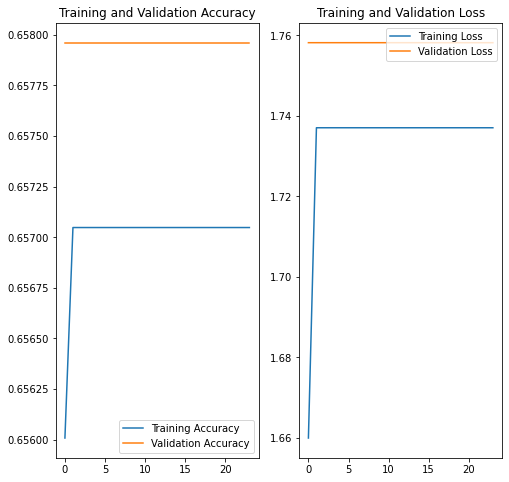

In [7]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Test Our Model

In [13]:
sunflower_url = "https://i.redd.it/x3fqgial7pi91.png"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 13ms/step
This image most likely belongs to Pornographic with a 100.00 percent confidence.


## Save our Dataset

In [13]:
import time

timestr = time.strftime("%Y%m%d-%H%M%S")
model.save("nvme_drive/Trained Models/" + timestr + "-SafetyNet", save_format="h5")